**main script**
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/testcode.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>

In [63]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

# Deterministic Full Waveform Inversion

In [177]:
from IPython.display import clear_output
import time
import numpy as np
# import cupy as cp
import scipy as sc
import matplotlib.pyplot as plt
labelsize = 16

from scipy.optimize import minimize
from func.propagation import prop2d, defmodel
from func.propagation_tf import simulate_obs
from func.inversion import J,second_order_derivative,gradiant
from func.velocity_model import check_model, gaussian2d

import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.metrics.pairwise import pairwise_distances
# print('GPU:',tf.config.list_physical_devices('GPU'))

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# import cupy as cp
device = 'cpu'

## Tensorflow mapping function
# def f_tf(u, vmin=2000, vmax=3000):
#     cdf = tfp.distributions.Normal(loc=0, scale=1).cdf(u)
#     # cdf =  tf.math.exp(-tf.math.square(u_tf)) / tf.math.sqrt(2.0 * np.pi)
#     v = (vmax - vmin) * cdf + vmin
#     return v

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    return v

# def f(u, a=2000, b=3000):
# 	'''
# 	Reparametrization mapping function from u -> v
# 	Unconstrained parameter -> Physical parameter space
# 	'''
# 	v = a+(b-a)/(1+np.exp(-u))

# 	return v


def f_inv(v, a=2000, b=3000):
	'''Inverse of the mapping function f^-1'''
	u = np.log(v-a) - np.log(b-v)

	return u


# Define cost function
def loglik_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	log_likelihood = -J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) / alpha
 
	return tf.cast(log_likelihood, tf.float32)

# Calculate gradient with Adjoint state method
def dloglik_du_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	dJ_dv = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)
	dloglik_dv = -dJ_dv / alpha
	dv_du = sc.misc.derivative(f,u)

	return tf.cast(dloglik_dv.flatten() * dv_du.flatten(), tf.float32)

def dlog_prob_du_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	dloglik_du = dloglik_du_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha)
	dlog_prior_du = -Q.dot(u.flatten())

	return dloglik_du + dlog_prior_du


## Forward modeling

dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  29 29 235
Number of receivers: 76


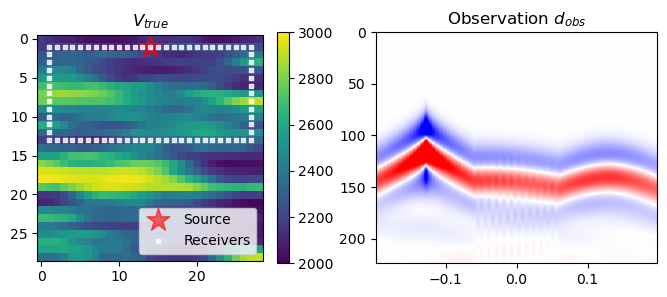

In [65]:
# Model size (nz,nx) = (29,29)
import pickle
# load data
filename = './data/u_29'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_29'
infile = open(filename, 'rb')
Q = pickle.load(infile)
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 29,29,235
vmin,vmax=2000,3000
izsrc, ixsrc = [1], [nx//2]
next = 10

# v_ref = gaussian2d(ranges=[20,5],variance=50,nx=[nz,nx],param=1,mean=2500)
# u_ref, Q = gaussian2d(ranges = [20,5],param=1,nx=[nz,nx],variance=1,mean=0)
u_ref = u_ref.flatten()
v_ref = f(u_ref)

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0], ax[1]-ax[0], at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 1 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx-1,interv)) #right
nrec = len(receivers_width)
# zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1))) # Right
# zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
# zxrec = zxrec1

zxrec5 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
zxrec6 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
zxrec7 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
zxrec = np.hstack((zxrec1,zxrec5,zxrec6,zxrec7))

zxrec = np.unique(zxrec,axis=1)
print("Number of receivers:", len(zxrec.flatten())//2)
# d_obs = simulate_obs(f(u_ref).resh, wsrc, zxsrc, at, az, ax, next, zxrec)
p = prop2d(wsrc,zxsrc,v_ref.reshape(nz,nx),at,az,ax,next,device)
d_obs = p[zxrec[0], zxrec[1], :]

plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

## Inversion with prior regularization term

In [66]:
# Define cost function
def objective_fwi_prior(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	loss_J = J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) / alpha
	print("Loss (J) = %.4f " % loss_J, end='')
	# Q: Likelihood part
	u = u.flatten()
	penalty = .5 * u.T.dot(Q.toarray()).dot(u)
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = loss_J + penalty
	print("Total loss = %.4f " % loss)
	# Save history
	global current_loss
	current_loss = np.array([loss,loss_J,penalty])

	return loss

# Calculate gradient with Adjoint state method
def gradiant_fwi_prior(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	receiver_depth = zxrec[0]
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

	return G.flatten()*sc.misc.derivative(f,u).flatten()/ alpha + Q.dot(u.flatten())

# Record loss history over each iterations
def callback(xk):
	global loss_tracker
	loss_tracker = np.vstack([loss_tracker,current_loss])
	
# minimize cost function
start = time.time()
u_init = np.zeros([nz*nx])   # Set initial velocity guess (u=0 -> v=2500)
v_init = f(u_init)   # Initial v
loss_tracker = np.empty((0,3))

std_noise = 0.1 # define the noise level
alpha = std_noise**2 # Regularization parameter/weight (Variance of observation noise)

resi = minimize(fun = objective_fwi_prior, 
               x0 = u_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha),
               method='L-BFGS-B', 
               # method='Newton-CG',
            #    bounds = np.full((len(u_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant_fwi_prior,
               options = {'disp':True, 'maxiter':150},
               callback=callback
              )
u_fwi = resi.x
print(u_fwi.shape)
print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))

Loss (J) = 408618.2099 Penalty term = 0.0000 Total loss = 408618.2099 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          841     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.08618D+05    |proj g|=  7.39038D+03
Loss (J) = 330707.7651 Penalty term = 0.1689 Total loss = 330707.9339 


/var/folders/p6/f7ctktns44sg8l4p29vhyf180000gn/T/ipykernel_98050/4234860350.py:41: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return G.flatten()*sc.misc.derivative(f,u).flatten()/ alpha + Q.dot(u.flatten())
 This problem is unconstrained.


KeyboardInterrupt: 

## FWI result

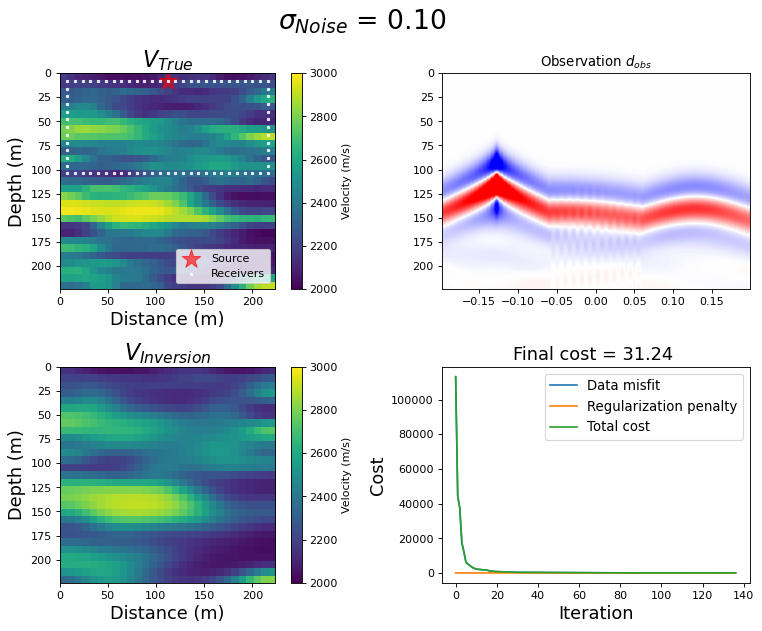

In [ ]:
# Plot deterministic FWI result and optimization history
v_fwi = f(u_fwi)

plt.figure(figsize=(10,8),dpi=80)
plt.suptitle("$\sigma_{Noise}$ = %.2f  " % std_noise,fontsize=labelsize+8)
# plt.suptitle("$Loss$ = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.subplot(2,2,1) 
plt.imshow(v_ref.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.scatter(zxsrc[1,:]*dz,zxsrc[0,:]*dx,marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:]*dz,zxrec[0,:]*dx,marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{True}$",fontsize=labelsize+4)

plt.subplot(2,2,2) 
# plt.imshow(v_init.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
# cbar = plt.colorbar()
# cbar.set_label("Velocity (m/s)")
# plt.xlabel('Distance (m)', fontsize=labelsize)
# plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.title("$V_{Initial\ Guess}$",fontsize=labelsize+4)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")

plt.subplot(2,2,3)
plt.imshow(v_fwi.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=100,alpha=0.6,label="Source")
# plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=0.1,alpha=0.8,label="Receivers")
# plt.legend(loc='lower right')
# plt.title("$V_{Inversion}$ with $\sigma_{Noise}$ = %.2f " % std_noise)
plt.title("$V_{Inversion}$",fontsize=labelsize+4)

plt.subplot(2,2,4)
plt.title("Final cost = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.plot(loss_tracker[:,1],label="Data misfit")
plt.plot(loss_tracker[:,2],label="Regularization penalty")
plt.plot(loss_tracker[:,0],label="Total cost")
plt.xlabel("Iteration",fontsize=labelsize)
plt.ylabel("Cost",fontsize=labelsize)
# plt.xlim(0,150)
# plt.ylim(0,800)
plt.legend(fontsize=labelsize-4)
plt.tight_layout()
plt.show()

# G-SVGD

##  Adjoint state method (Jacobian)

In [185]:
# Define the generator network G
def make_generator(l2=0.01):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(256, activation='relu', input_shape=(841,), kernel_regularizer=tf.keras.regularizers.l2(l2)))
    model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2)))
    model.add(tf.keras.layers.Dense(841, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(l2)))
    return model

# Initialize the generator
generator = make_generator(l2=0.01)

# Sample from the prior distribution with precision matrix Q to initialize particles
n_particles = 1
u_dim = 841
p_mean = tf.zeros(nz*nx, dtype=tf.float32)
# p_cov = tf.eye(u_dim, dtype=tf.float32)
p_cov = tf.cast(sc.sparse.linalg.inv(Q).toarray(), tf.float32)
p_dist = tfp.distributions.MultivariateNormalTriL(loc=p_mean, scale_tril=tf.linalg.cholesky(p_cov))
u = p_dist.sample(n_particles)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)

for i in range(1000):
    # Record operations performed on tensors inside this context
    with tf.GradientTape() as tape:
        # Generate particles by passing noise through the generator
        v_particles = generator(u)
        # Reshape particles into a tensor of shape (n_particles, nx, nz)
        v_particles = tf.reshape(v_particles, (n_particles, nx, nz))

    print("Iter",i,J(v_particles[0].numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device))

    # Compute gradients of J with respect to v_particles
    grad_dJ_dv = tf.convert_to_tensor([gradiant(vi.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) for vi in v_particles], dtype=tf.float32)
    grad_dJ_dv = tf.reshape(grad_dJ_dv, shape=(n_particles*nz*nx))
    # Compute gradients of v_particles with respect to generator weights
    jac_dv_dW = tape.jacobian(v_particles, generator.trainable_variables)
    jac_dv_dW = tf.reshape(jac_dv_dW[0], shape=(n_particles*nz*nx, tf.size(generator.trainable_variables[0])))

    # Merge gradients 
    gradients = tf.linalg.matmul(jac_dv_dW, tf.expand_dims(grad_dJ_dv, axis=-1), transpose_a=True)

    # Update model weights using the gradients and an optimizer
    optimizer.apply_gradients(zip(gradients, generator.trainable_variables))


Iter 0 73661.53816345235
Iter 1 73661.53493063325
Iter 2 73661.53179122775
Iter 3 73661.52874933316
Iter 4 73661.52580720132
Iter 5 73661.5229666258
Iter 6 73661.52022878396
Iter 7 73661.51759480867
Iter 8 73661.51506553257
Iter 9 73661.51264148507
Iter 10 73661.51032305423
Iter 11 73661.50811040797
Iter 12 73661.50600336632
Iter 13 73661.50400164053
Iter 14 73661.50210459976
Iter 15 73661.50031140842
Iter 16 73661.4986209168
Iter 17 73661.49703178502
Iter 18 73661.49554235637
Iter 19 73661.49415074647
Iter 20 73661.49285483727
Iter 21 73661.49165225183
Iter 22 73661.4905403362
Iter 23 73661.48951623985
Iter 24 73661.48857693763
Iter 25 73661.48771915148
Iter 26 73661.48693944718
Iter 27 73661.48623422315
Iter 28 73661.48559973638
Iter 29 73661.48503213722
Iter 30 73661.48452748878
Iter 31 73661.48408176887
Iter 32 73661.48369093557
Iter 33 73661.48335094955


## Automatic differentiation

In [179]:
# Define the generator network G
def make_generator(l2=0.01):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(256, activation='relu', input_shape=(841,), kernel_regularizer=tf.keras.regularizers.l2(l2)))
    model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2)))
    model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2)))
    model.add(tf.keras.layers.Dense(841, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(l2)))
    return model

# Initialize the generator
generator = make_generator(l2=0.01)

# Sample from the prior distribution with precision matrix Q to initialize particles
n_particles = 1
u_dim = 841
p_mean = tf.zeros(nz*nx, dtype=tf.float32)
p_cov = tf.cast(sc.sparse.linalg.inv(Q).toarray(), tf.float32)
# p_cov = tf.eye(u_dim, dtype=tf.float32)
p_dist = tfp.distributions.MultivariateNormalTriL(loc=p_mean, scale_tril=tf.linalg.cholesky(p_cov))
u = p_dist.sample(n_particles)
# Initialize optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
num_epochs = 500
noise_std = 0.001

# Training loop
for epoch in range(40):
    with tf.GradientTape() as tape:
        tape.watch(generator.trainable_variables)
        # Generate particles by passing noise through the generator
        v_particles = generator(u)
        # Reshape particles into a tensor of shape (n_particles, nx, nz)
        v_particles = tf.reshape(v_particles, (n_particles, nx, nz))
        J_particles = []
        for v in v_particles:
            # Run simulations
            d = simulate_obs(v, wsrc, zxsrc, at, az, ax, next, zxrec)
            J_i = .5 * tf.reduce_sum((d - d_obs)**2)
            # print(J)
            J_particles.append(J_i)
            loss = tf.reduce_mean(J_particles)
        
        # Compute gradients of J_particles with respect to generator weights
        gradients = tape.gradient(loss, generator.trainable_variables)
        gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=0.1)
        
        # Add Gaussian noise to the gradients
        noisy_gradients = []
        for grad in gradients:
            noisy_grad = grad + tf.random.normal(grad.shape, stddev=noise_std)
            # noisy_grad = grad + noise_std * tf.ones(grad.shape)
            noisy_gradients.append(noisy_grad)
        gradients = noisy_gradients
        print(tf.math.reduce_max(tf.math.abs(gradients[0])))

    # Update model weights using the gradients and the optimizer
    optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    
    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {tf.reduce_mean(loss)}")


tf.Tensor(0.004812365, shape=(), dtype=float32)
Epoch 1/500, Loss: 73661.4765625
tf.Tensor(0.0046619526, shape=(), dtype=float32)
Epoch 2/500, Loss: 73672.2890625
tf.Tensor(0.0050443653, shape=(), dtype=float32)
Epoch 3/500, Loss: 73663.7734375
tf.Tensor(0.005075818, shape=(), dtype=float32)
Epoch 4/500, Loss: 73661.5
tf.Tensor(0.0045806863, shape=(), dtype=float32)
Epoch 5/500, Loss: 73661.5
tf.Tensor(0.0044178627, shape=(), dtype=float32)
Epoch 6/500, Loss: 73661.578125
tf.Tensor(0.005152583, shape=(), dtype=float32)
Epoch 7/500, Loss: 73661.484375
tf.Tensor(0.0044292123, shape=(), dtype=float32)
Epoch 8/500, Loss: 73661.578125
tf.Tensor(0.004888312, shape=(), dtype=float32)
Epoch 9/500, Loss: 73661.484375
tf.Tensor(0.004756858, shape=(), dtype=float32)
Epoch 10/500, Loss: 73661.8046875
tf.Tensor(0.005241884, shape=(), dtype=float32)
Epoch 11/500, Loss: 73661.734375
tf.Tensor(0.0046238396, shape=(), dtype=float32)
Epoch 12/500, Loss: 73661.4765625
tf.Tensor(0.004898348, shape=(), dty

KeyboardInterrupt: 